In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [162]:
class LassoReg:
    def __init__(self, step_size, max_iterations, l1_penalty, tolerance):
        self.step_size = step_size
        self.max_iterations = max_iterations
        self.l1_penalty = l1_penalty
        self.tolerance = tolerance
        self.m = None
        self.n = None
        self.W = None
        self.X = None
        self.Y = None
        self.J = []  # Initialize J as an empty list
        self.iterations = None

    def fit(self, X, Y, algo, agents=None):
        self.m, self.n = X.shape
        self.W = np.zeros(self.n)
        self.X = X
        self.Y = Y

        if algo == "gd":
            self.gradient_descent()
        elif algo == "admm":
            self.admm_fit()
        elif algo == "distributed_admm":
            self.distributed_admm(agents)
        else:
            raise ValueError("Invalid algorithm")

    def gradient_descent(self):
        for i in range(1, self.max_iterations + 1):
            Y_predict = self.predict(self.X).flatten()

            soft_term = self.soft_threshold(self.W, self.l1_penalty)
            dW = (-2 * self.X.T @ (self.Y - Y_predict) + soft_term) / self.m
            new_W = self.W - self.step_size * dW

            if np.linalg.norm(new_W - self.W) < self.tolerance:
                break

            self.J.append((np.linalg.norm(new_W - self.W),))
            self.W = new_W
            self.iterations = i

    def admm_fit(self):
        rho = self.step_size
        z = np.zeros(self.n)
        u = np.zeros(self.n)
        I = np.eye(self.n)

        abs_tol = self.tolerance
        rel_tol = abs_tol * 100

        for i in range(1, self.max_iterations + 1):
            last_z = z

            self.W = np.linalg.solve(self.X.T @ self.X + rho * I, self.X.T @ self.Y + rho * (z - u))
            z = self.soft_threshold(self.W + u, self.l1_penalty / rho)
            u = u + self.W - z

            r_norm = np.linalg.norm(self.W - z)  # primary residual
            s_norm = np.linalg.norm(-rho * (z - last_z))  # dual residual
            tol_prim = np.sqrt(self.n) * abs_tol + rel_tol * max(np.linalg.norm(self.W), np.linalg.norm(-z))
            tol_dual = np.sqrt(self.n) * abs_tol + rel_tol * np.linalg.norm(rho * u)

            self.iterations = i
            self.J.append(np.array([r_norm, s_norm, tol_prim, tol_dual]))

            if r_norm < tol_prim and s_norm < tol_dual:
                break

        self.W = self.W.reshape(1, -1)

    def distributed_admm(self, agents):
        rho = self.step_size
        z = np.zeros(self.n)
        I = np.eye(self.n)

        abs_tol = self.tolerance
        rel_tol = abs_tol * 100
        converged = False

        r, c = self.X.shape
        rows_per_agent = r // agents
        total_rows_used = rows_per_agent * agents

        print(f"Total rows used: {total_rows_used}")
        print(f"Rows per agent: {rows_per_agent}")

        splitted_X = self.X[:total_rows_used, :].reshape((rows_per_agent, agents, c))
        splitted_Y = np.reshape(self.Y[:total_rows_used], (rows_per_agent, agents))
        self.W = np.zeros((agents, c))
        u = np.zeros((agents, c))

        for i in range(1, self.max_iterations + 1):
            last_z = z
            for j in range(agents):
                self.W[j, :] = np.linalg.solve(splitted_X[:, j, :].T @ splitted_X[:, j, :] + (rho / 2) * I, splitted_X[:, j, :].T @ splitted_Y[:, j] + (rho / 2) * (z - u[j, :]))
            
            # Fusion center aggregates information from agents
            global_W = np.mean(self.W, axis=0)
            global_u = np.mean(u, axis=0)

            # Fusion center updates z based on aggregated information
            z = self.soft_threshold(global_W + global_u, self.l1_penalty / (rho * agents))

            # Distribute updated information to agents
            for j in range(agents):
                u[j, :] = u[j, :] + (self.W[j, :] - z)
                
            global_u = np.mean(u, axis=0)    

            r_norm = np.linalg.norm(global_W - z)  # primary residual
            s_norm = np.linalg.norm(-rho * (z - last_z))  # dual residual
            tol_prim = np.sqrt(self.n) * abs_tol + rel_tol * max(np.linalg.norm(global_W), np.linalg.norm(-z))
            tol_dual = np.sqrt(self.n) * abs_tol + rel_tol * np.linalg.norm(rho * global_u)

            self.iterations = i
            self.J.append((r_norm, s_norm, tol_prim, tol_dual))

            if r_norm < tol_prim and s_norm < tol_dual:
                converged = True
                break

        self.W = global_W.reshape(1, -1)

    def predict(self, X):
        return X @ self.W.T.flatten()

    def loss_function(self, Y, Y_predict, W):
        return 0.5 * np.sum((Y - Y_predict) ** 2) + self.l1_penalty * np.linalg.norm(W, 1)

    def soft_threshold(self, w, th):
        return np.maximum(0, w - th) - np.maximum(0, -w - th)

    def mean_squared_error(self, Y_true, Y_predicted):
        return np.mean((Y_true - Y_predicted) ** 2)


In [163]:
def prediction_plot(Y_test, Y_pred, title):
    plt.scatter(Y_test, Y_pred, color='brown', label='Predicted vs. Measured')
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4, label='Ideal')
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

def loss_plot(J, title):
    plt.plot(J, color='brown', label='Total Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

def loss_plot_admm(J, title):
    r_loss = [row[0] for row in J]  
    s_loss = [row[1] for row in J]  

    plt.plot(r_loss, label='Primary Residual', color='purple')
    plt.plot(s_loss, label='Dual Residual', color='green')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()


# First test on simple generated dataset

In [164]:
n_features = 3

X_num = np.random.rand(300, n_features)
X_cat = np.random.randint(0, 2, (300, 1))
X_cat_one_hot = pd.get_dummies(X_cat.flatten(), prefix='cat', drop_first=True).values
X = np.concatenate((X_num, X_cat_one_hot), axis=1)

y = 2 * X[:, 0] + X[:, 1] + 0.1 * np.random.randn(300)

In [165]:
print(X.shape)

X_dataframe = pd.DataFrame(X, columns=["X1", "X2", "X3", "cat_0"])
print(X_dataframe.head())

(300, 4)
         X1        X2        X3  cat_0
0  0.584726  0.782106  0.577045    1.0
1  0.179441  0.690211  0.736506    1.0
2  0.677379  0.706744  0.938218    0.0
3  0.576946  0.651138  0.954162    0.0
4  0.043265  0.461748  0.060724    1.0


In [166]:
y_dataframe = pd.DataFrame(y, columns=["Y"])
print(y_dataframe.head())

          Y
0  1.985797
1  0.968797
2  2.058719
3  1.725025
4  0.526098


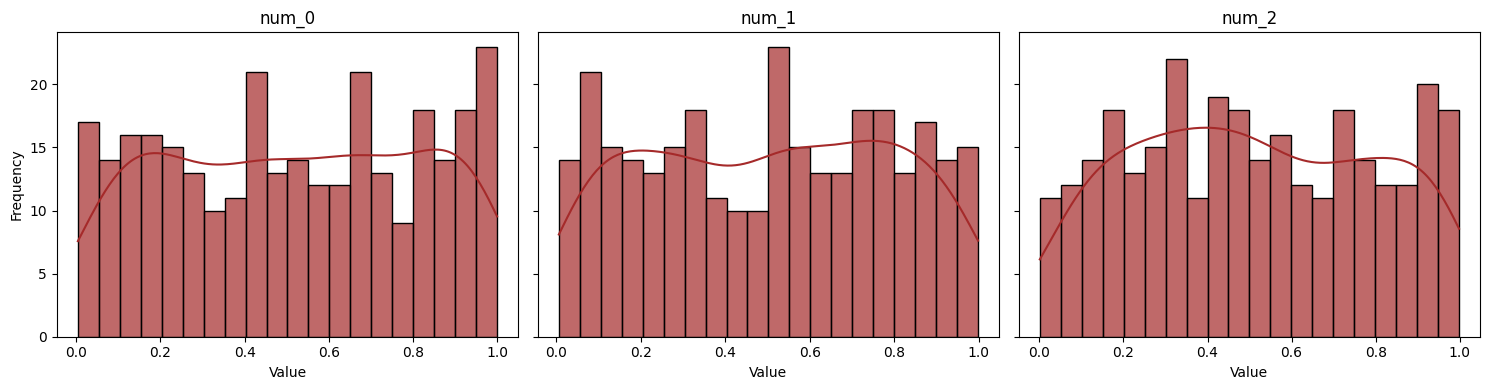

In [167]:
# visualize distribution of data
fig, axes = plt.subplots(1, n_features, figsize=(15, 4), sharey=True)

for i in range(n_features):
    sns.histplot(X[:, i], bins=20, kde=True, ax=axes[i], color='brown', alpha=0.7)
    axes[i].set_title(f'num_{i}')
    axes[i].set_xlabel('Value')

# Adding a common y-axis label
axes[0].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

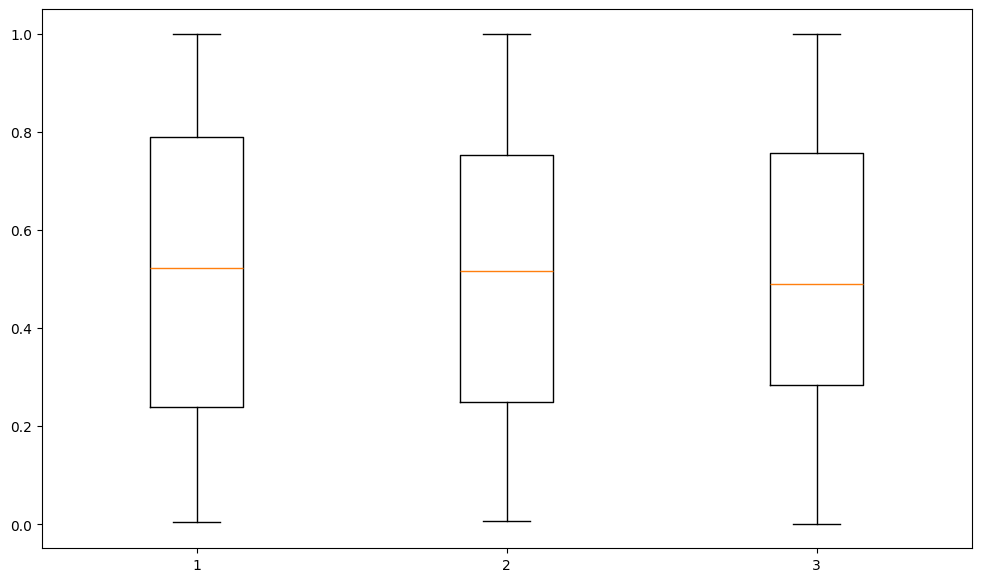

In [168]:
plt.figure(figsize=(12, 7))
plt.boxplot(X_num)
plt.show()

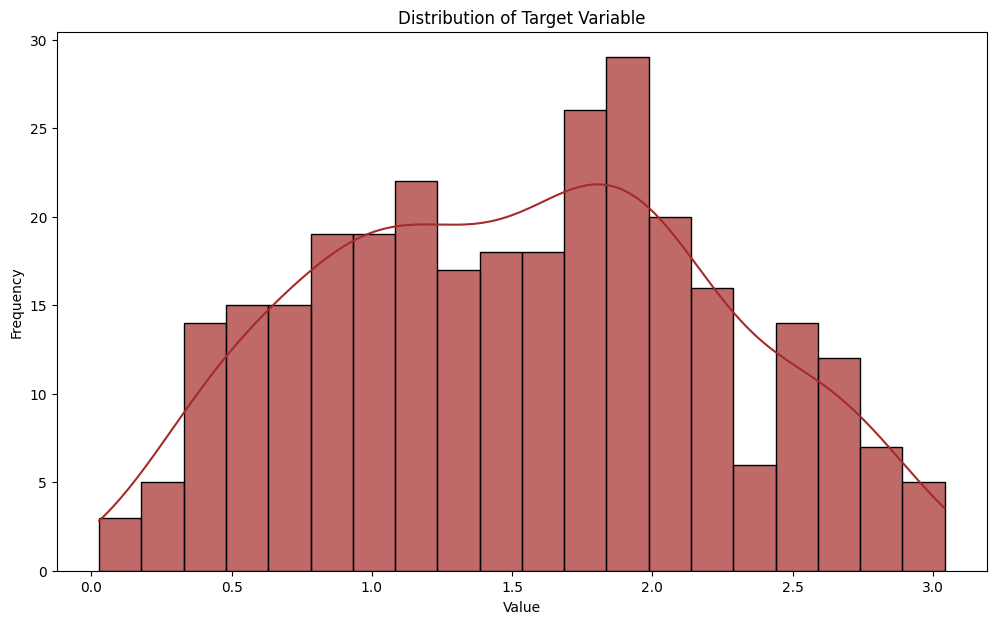

In [169]:
#visualize distribution of target variable
plt.figure(figsize=(12, 7))
sns.histplot(y, bins=20, kde=True, color='brown', alpha=0.7)
plt.title('Distribution of Target Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [171]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [172]:
#lasso parameters
step_size = 0.1
max_iterations = 10000
l1_penalty = 0.1
tolerance = 1e-3
agents = 5

Lasso Gradient Descent 

In [173]:
# Lasso GD
start_time = time.time()
lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_gd.fit(X_train, y_train, algo="gd")
y_pred_gd = lasso_gd.predict(X_test)
gd_time = time.time() - start_time
print(f"GD time: {gd_time}")
iterations_gd = lasso_gd.iterations
print(f"GD iterations: {iterations_gd}")

GD time: 0.011008262634277344
GD iterations: 170


In [174]:
# metrics
mse_gd = mean_squared_error(y_test, y_pred_gd)
r2_gd = r2_score(y_test, y_pred_gd)
mae_gd = mean_absolute_error(y_test, y_pred_gd)

print(f"GD MSE: {mse_gd}")
print(f"GD R2: {r2_gd}")
print(f"GD MAE: {mae_gd}")

GD MSE: 0.01253563076209636
GD R2: 0.977465080968291
GD MAE: 0.08578831297201184


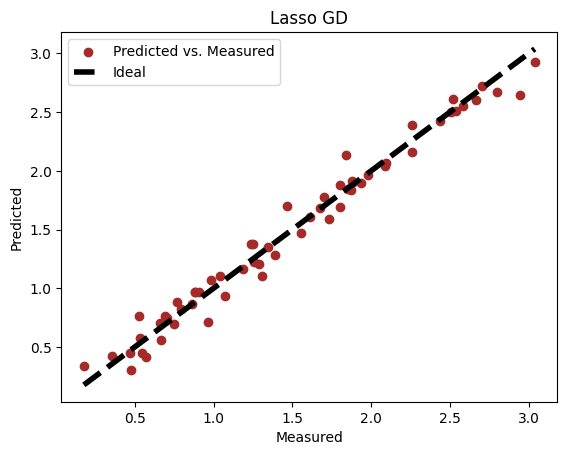

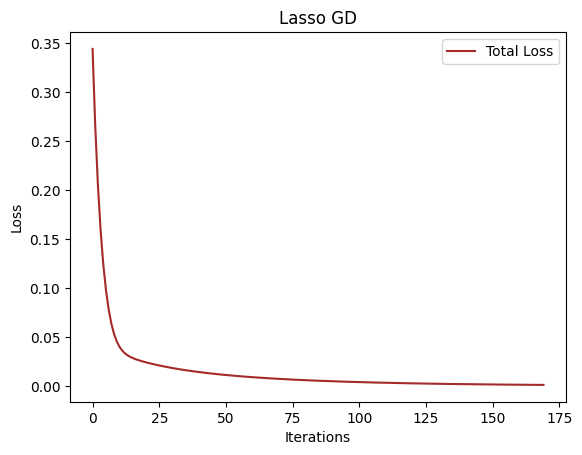

In [175]:
# plot results
prediction_plot(y_test, y_pred_gd, 'Lasso GD')

loss_plot(lasso_gd.J, 'Lasso GD')

Lasso Centralized ADMM

In [176]:
# Lasso ADMM
start_time = time.time()
lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_admm.fit(X_train, y_train, algo="admm")
y_pred_admm = lasso_admm.predict(X_test)
admm_time = time.time() - start_time
print(f"ADMM time: {admm_time}")
iterations_admm = lasso_admm.iterations
print(f"ADMM iterations: {iterations_admm}")

ADMM time: 0.0010004043579101562
ADMM iterations: 3


In [177]:
# metrics
mse_admm = mean_squared_error(y_test, y_pred_admm)
r2_admm = r2_score(y_test, y_pred_admm)
mae_admm = mean_absolute_error(y_test, y_pred_admm)

print(f"ADMM MSE: {mse_admm}")
print(f"ADMM R2: {r2_admm}")
print(f"ADMM MAE: {mae_admm}")

ADMM MSE: 0.01298638850429134
ADMM R2: 0.9766547675970649
ADMM MAE: 0.08531566331924252


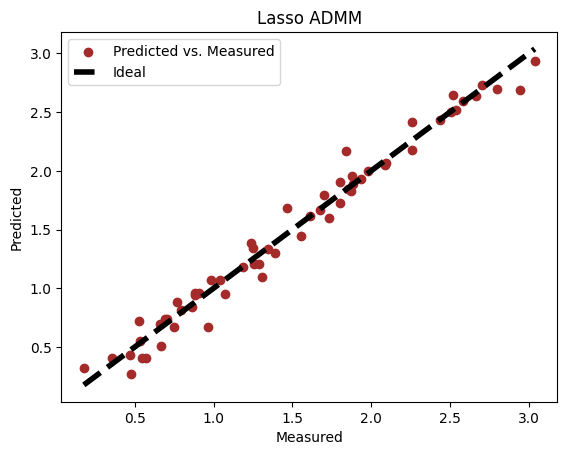

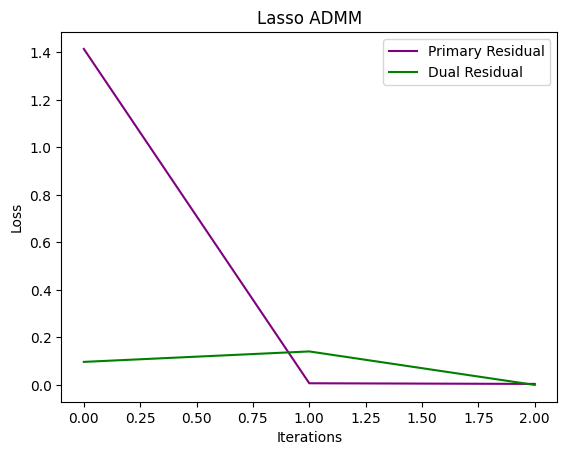

In [178]:
# plot results
prediction_plot(y_test, y_pred_admm, 'Lasso ADMM')

loss_plot_admm(lasso_admm.J, 'Lasso ADMM')

Lasso Distributed ADMM

In [179]:
# Lasso Distributed ADMM
start_time = time.time()
lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_distributed_admm.fit(X_train, y_train, algo="distributed_admm", agents=agents)
y_pred_distributed_admm = lasso_distributed_admm.predict(X_test)
distributed_admm_time = time.time() - start_time
print(f"Distributed ADMM time: {distributed_admm_time}")
iterations_distributed_admm = lasso_distributed_admm.iterations
print(f"Distributed ADMM iterations: {iterations_distributed_admm}")

Total rows used: 240
Rows per agent: 48
Distributed ADMM time: 0.003993988037109375
Distributed ADMM iterations: 3


In [180]:
# metrics
mse_distributed_admm = mean_squared_error(y_test, y_pred_distributed_admm)
r2_distributed_admm = r2_score(y_test, y_pred_distributed_admm)
mae_distributed_admm = mean_absolute_error(y_test, y_pred_distributed_admm)

print(f"Distributed ADMM MSE: {mse_distributed_admm}")
print(f"Distributed ADMM R2: {r2_distributed_admm}")
print(f"Distributed ADMM MAE: {mae_distributed_admm}")

Distributed ADMM MSE: 0.012965732982589299
Distributed ADMM R2: 0.9766918993950532
Distributed ADMM MAE: 0.08543169757202257


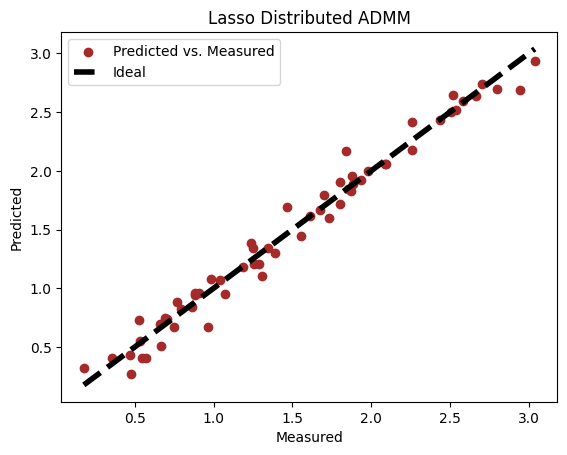

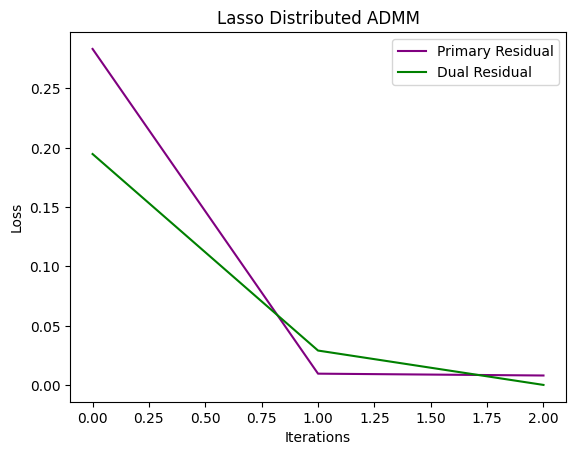

In [181]:
# plot results
prediction_plot(y_test, y_pred_distributed_admm, 'Lasso Distributed ADMM')

loss_plot_admm(lasso_distributed_admm.J, 'Lasso Distributed ADMM')

# Test on a second synthetically generated dataset

In [182]:
n_num_features = 8
n_cat_features = 2
n_samples = 1000

X_numeric = np.column_stack((
    np.random.normal(loc=7, scale=2, size=(n_samples, 1)),  
    np.random.uniform(low=2, high=12, size=(n_samples, 1)),  
    np.random.exponential(scale=3, size=(n_samples, 1)),  
    np.random.poisson(lam=4, size=(n_samples, 1)),  
    np.random.gamma(shape=3, scale=2, size=(n_samples, 1)),  
    np.random.logistic(loc=-2, scale=1, size=(n_samples, 1)),  
    np.random.chisquare(df=3, size=(n_samples, 1)),  
    np.random.power(a=4, size=(n_samples, 1))                                       
))

X_categorical = np.random.choice([1, 2, 3, 4], size=(n_samples, n_cat_features))

X = np.concatenate((X_numeric, X_categorical), axis=1)

In [518]:
true_weights_numeric = np.random.uniform(-10, 10, n_num_features)

true_weights_categorical = np.random.uniform(-2, 2, n_cat_features)

y = (X_numeric @ true_weights_numeric + X_categorical @ true_weights_categorical + 14 + 0.25 * np.random.randn(n_samples) + np.sin(0.1 * X_numeric[:, 0]) + np.exp(0.35 * X_numeric[:, 1]) + np.cos(0.7 * X_numeric[:, 2]) * X_categorical[:, 0] + np.tanh(0.1 * X_numeric[:, 4]) * X_categorical[:, 1] + 0.45 * np.random.uniform(-10, 71, n_samples))

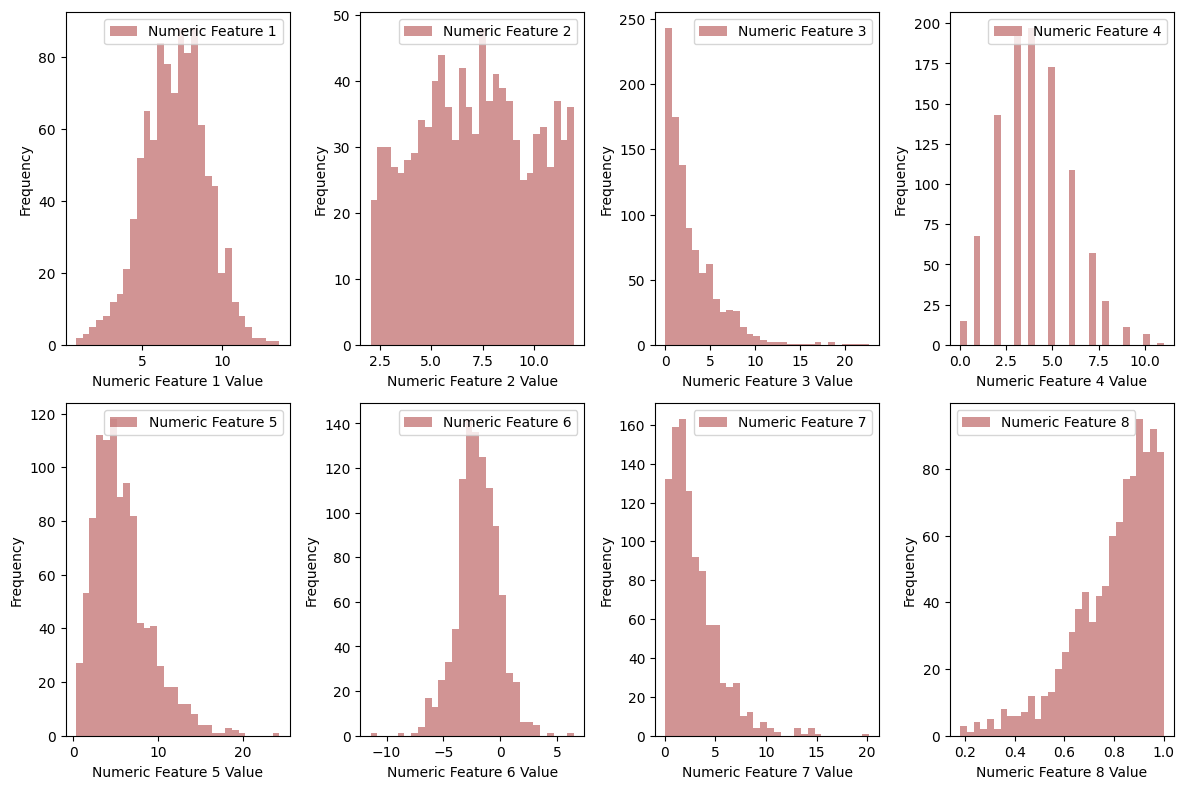

In [447]:
fig, axes = plt.subplots(nrows=2, ncols=n_num_features // 2, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.hist(X_numeric[:, i], bins=30, alpha=0.5, label=f'Numeric Feature {i + 1}', color='brown')
    ax.legend()
    ax.set_xlabel(f'Numeric Feature {i + 1} Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

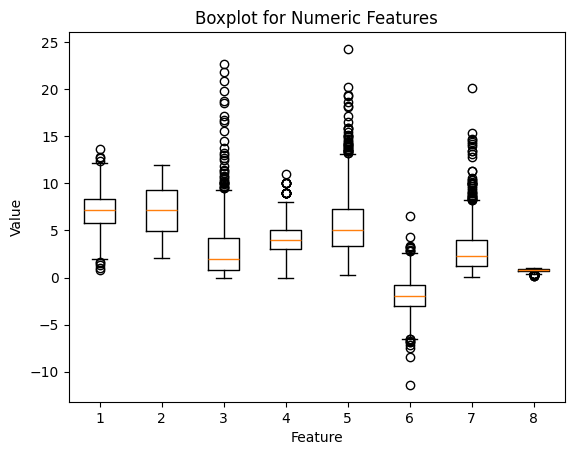

In [432]:
# boxplot for numeric features
plt.boxplot(X_numeric)
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('Boxplot for Numeric Features')
plt.show()

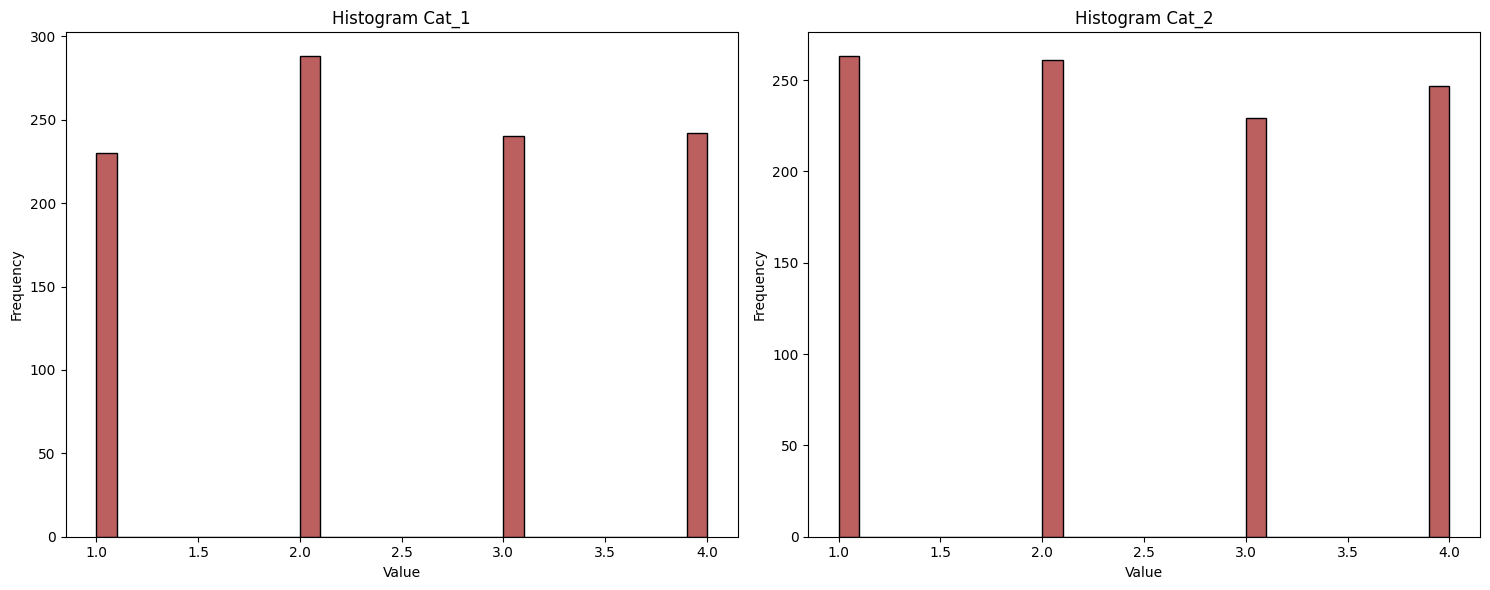

In [433]:
# visualize the distribution of categorical features
df_cat = pd.DataFrame(X_categorical, columns=[f'Cat_{i + 1}' for i in range(n_cat_features)])

plt.figure(figsize=(15, 6))
for i in range(n_cat_features):
    plt.subplot(1, n_cat_features, i + 1)
    sns.histplot(df_cat[f'Cat_{i + 1}'], bins=30, color='brown', edgecolor='black')
    plt.title(f'Histogram Cat_{i + 1}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

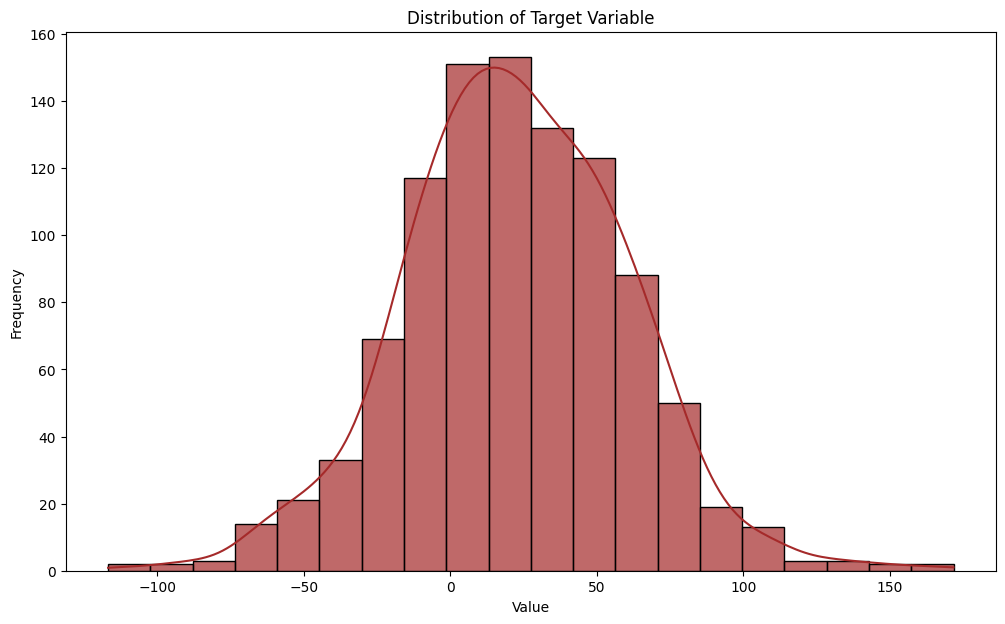

In [519]:
# visualize distribution of target variable
plt.figure(figsize=(12, 7))
sns.histplot(y, bins=20, kde=True, color='brown', alpha=0.7)
plt.title('Distribution of Target Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [520]:
# one-hot encode the categorical features
X_one_hot = pd.get_dummies(df_cat, columns=df_cat.columns, drop_first=True).values

X = np.concatenate((X_numeric, X_one_hot), axis=1)

In [521]:
# split the data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)

In [523]:
# normalize the data
scaler = MinMaxScaler()
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)

In [524]:
#lasso parameters
step_size = 0.1
max_iterations = 100000
l1_penalty = 0.1
tolerance = 1e-3
agents = 5

In [525]:
# Lasso Gd
start_time = time.time()
lasso_gd_2 = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_gd_2.fit(X_train_2, y_train_2, algo="gd")
y_pred_gd_2 = lasso_gd_2.predict(X_test_2)
gd_time_2 = time.time() - start_time
print(f"GD time: {gd_time_2}")
iterations_gd_2 = lasso_gd_2.iterations
print(f"GD iterations: {iterations_gd_2}")


GD time: 0.6349976062774658
GD iterations: 1974


In [526]:
# metrics
mse_gd_2 = mean_squared_error(y_test_2, y_pred_gd_2)
r2_gd_2 = r2_score(y_test_2, y_pred_gd_2)
mae_gd_2 = mean_absolute_error(y_test_2, y_pred_gd_2)

print(f"GD MSE: {mse_gd_2}")
print(f"GD R2: {r2_gd_2}")
print(f"GD MAE: {mae_gd_2}")

GD MSE: 228.63250495521999
GD R2: 0.8432920655344379
GD MAE: 12.14121405615259


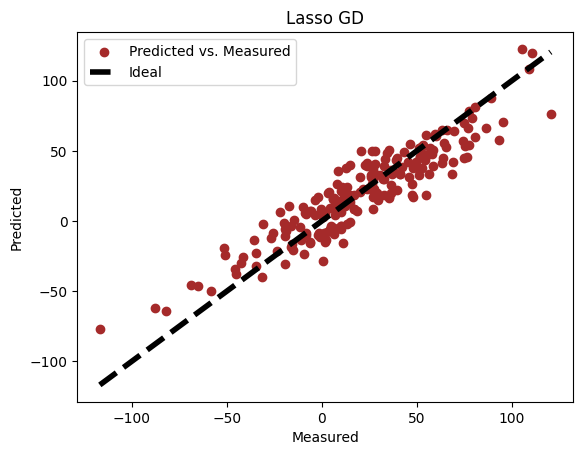

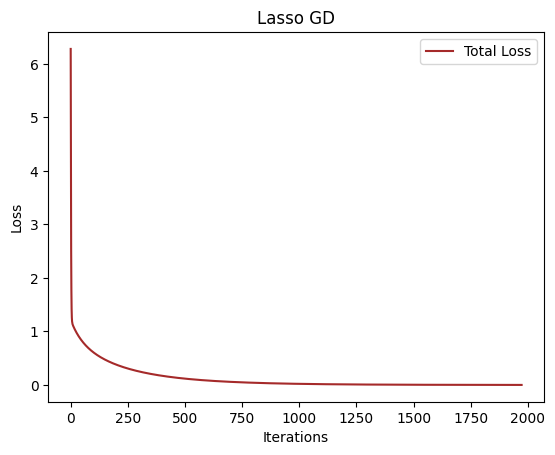

In [527]:
# plot results
prediction_plot(y_test_2, y_pred_gd_2, 'Lasso GD')

loss_plot(lasso_gd_2.J, 'Lasso GD')

In [528]:
# Lasso ADMM
start_time = time.time()
lasso_admm_2 = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_admm_2.fit(X_train_2, y_train_2, algo="admm")
y_pred_admm_2 = lasso_admm_2.predict(X_test_2)
admm_time_2 = time.time() - start_time
print(f"ADMM time: {admm_time_2}")
iterations_admm_2 = lasso_admm_2.iterations
print(f"ADMM iterations: {iterations_admm_2}")

ADMM time: 0.0029973983764648438
ADMM iterations: 3


In [529]:
# metrics
mse_admm_2 = mean_squared_error(y_test_2, y_pred_admm_2)
r2_admm_2 = r2_score(y_test_2, y_pred_admm_2)
mae_admm_2 = mean_absolute_error(y_test_2, y_pred_admm_2)

print(f"ADMM MSE: {mse_admm_2}")
print(f"ADMM R2: {r2_admm_2}")
print(f"ADMM MAE: {mae_admm_2}")

ADMM MSE: 222.19363985284218
ADMM R2: 0.8477053542341075
ADMM MAE: 12.022750203314718


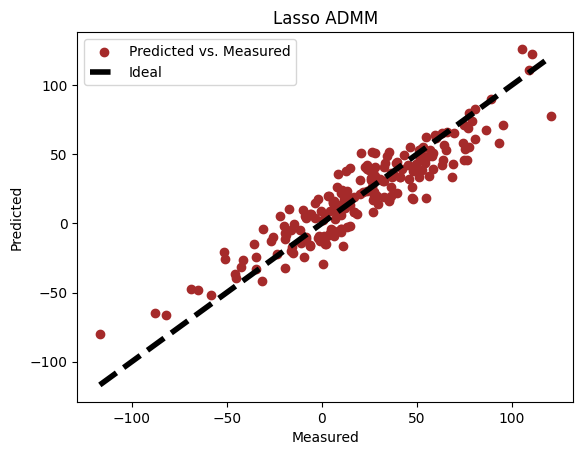

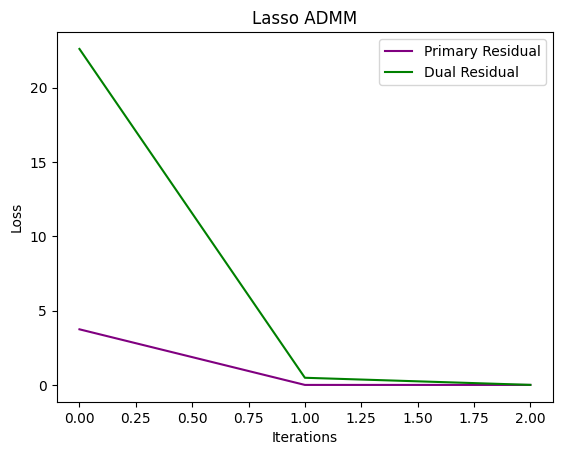

In [530]:
# plot results
prediction_plot(y_test_2, y_pred_admm_2, 'Lasso ADMM')

loss_plot_admm(lasso_admm_2.J, 'Lasso ADMM')

In [531]:
# Lasso Distributed ADMM
start_time = time.time()
lasso_distributed_admm_2 = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_distributed_admm_2.fit(X_train_2, y_train_2, algo="distributed_admm", agents=agents)
y_pred_distributed_admm_2 = lasso_distributed_admm_2.predict(X_test_2)
distributed_admm_time_2 = time.time() - start_time
print(f"Distributed ADMM time: {distributed_admm_time_2}")
iterations_distributed_admm_2 = lasso_distributed_admm_2.iterations
print(f"Distributed ADMM iterations: {iterations_distributed_admm_2}")

Total rows used: 800
Rows per agent: 160
Distributed ADMM time: 0.0029790401458740234
Distributed ADMM iterations: 4


In [532]:
# metrics
mse_distributed_admm_2 = mean_squared_error(y_test_2, y_pred_distributed_admm_2)
r2_distributed_admm_2 = r2_score(y_test_2, y_pred_distributed_admm_2)
mae_distributed_admm_2 = mean_absolute_error(y_test_2, y_pred_distributed_admm_2)

print(f"Distributed ADMM MSE: {mse_distributed_admm_2}")
print(f"Distributed ADMM R2: {r2_distributed_admm_2}")
print(f"Distributed ADMM MAE: {mae_distributed_admm_2}")

Distributed ADMM MSE: 222.45880040306093
Distributed ADMM R2: 0.8475236094636749
Distributed ADMM MAE: 12.019112746649073


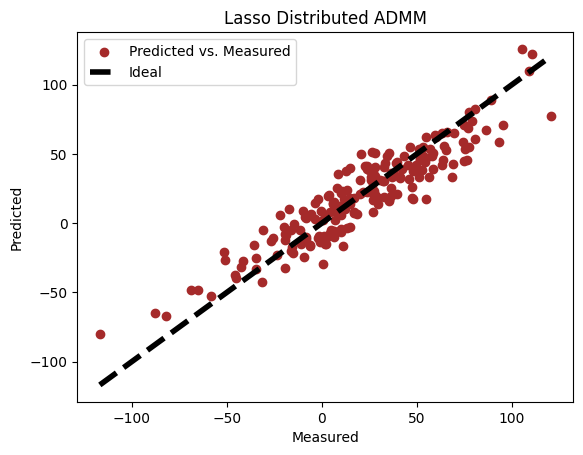

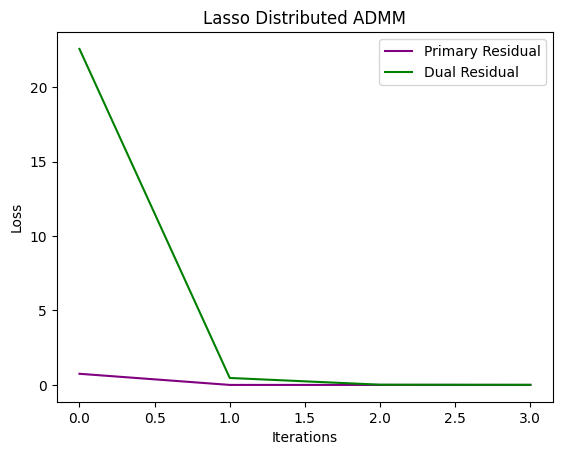

In [533]:
# plot results
prediction_plot(y_test_2, y_pred_distributed_admm_2, 'Lasso Distributed ADMM')

loss_plot_admm(lasso_distributed_admm_2.J, 'Lasso Distributed ADMM')

Riordinare codice
//
Vedi se house pricing cambia cambiando parametri
//
sennò fare considerazioni al variare dei parametri
//
Generare nuovo set sintetico se hai voglia
